Design for robust performance for a plant with uncertain gain and neglected high frequency dynamics. We perform no model reduction: numerical results or even feasibility may be very sensitive to parameters like frequency gridding. Also the computation of the frequency response of the sensitivity functions may be inaccurate if the controller order is too high.
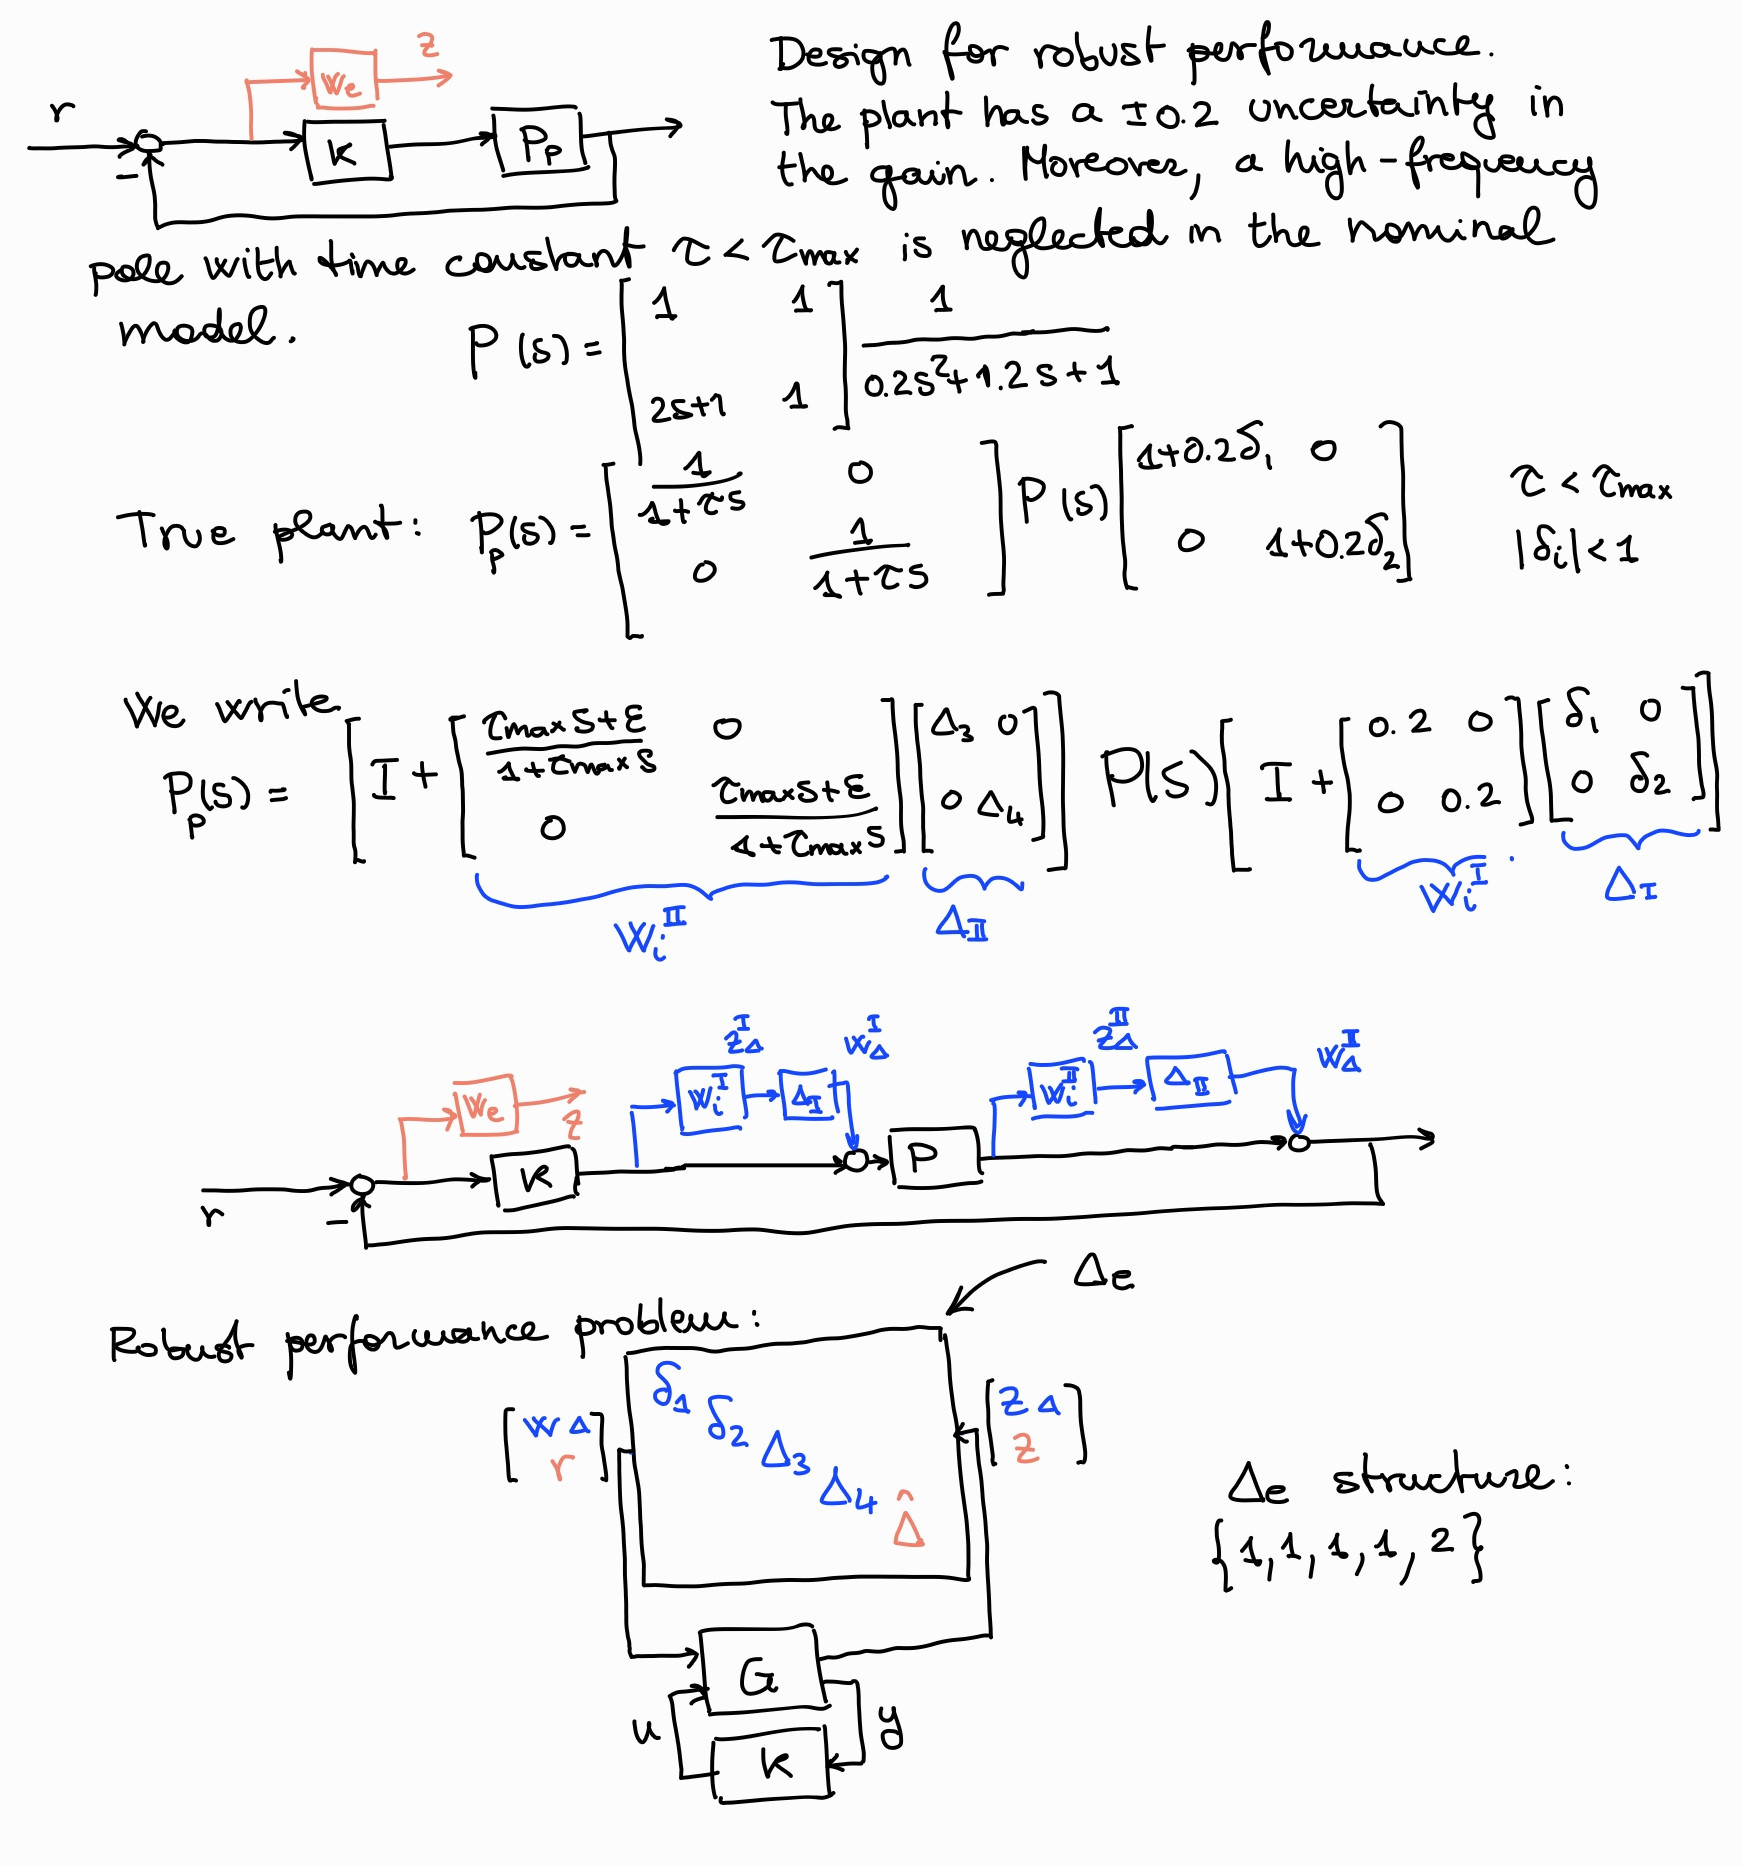

In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb
s= ct.tf('s')

Main program

In [2]:
# Plant P
den = [0.2, 1.2, 1]
P = ct.tf([[[1], [1]],
              [[2, 1], [2]]],
             [[den, den],
              [den, den]])
display("Nominal plant transfer function", P)

'Nominal plant transfer function'

TransferFunction(
[[array([1]), array([1])],
 [array([2, 1]), array([2])]],
[[array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])],
 [array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])]],
outputs=2, inputs=2)

Define performance weight and uncertainty weight 

In [3]:
# Uncertainty block weight Wi1
gainmax = 0.2 # Weight on the gain matrix
Wi_1 = ct.ss([],[],[],gainmax)
Wi1 = Wi_1.append(Wi_1) 

# Uncertainty block weight Wi2
# Max time constant of the neglected dynamics
taumax = 2
# Uncertainty block weight Wi
ei = 1e-4
s = ct.tf('s')
Wi_2 = ct.ss((taumax * s + ei)/(1 + taumax * s ))
Wi2 = Wi_2.append(Wi_2)

# Performance weight We (weight on S)
M = 5
e = 1e-4
wb = 0.09 # Crossover frequency
We_1 = ct.ss(rb.weightS(wb, M, e, 1))
We = We_1.append(We_1) 

Construct the LFT

In [4]:
Wi1.input_labels = ['u[0]', 'u[1]']
Wi1.output_labels = ['zdelta1[0]', 'zdelta1[1]']
Wi2.input_labels = ['yp[0]', 'yp[1]']
Wi2.output_labels = ['zdelta2[0]', 'zdelta2[1]']
We.input_labels = ['y[0]', 'y[1]']
We.output_labels = ['z[0]', 'z[1]']
P.input_labels = ['up[0]','up[1]']
P.output_labels = ['yp[0]','yp[1]']

# Summing junctions from uncertain blocks
sumdelta1 = ct.summing_junction(inputs=['u','wdelta1'], output='up', dimension=2)
sumdelta2 = ct.summing_junction(inputs=['yp','wdelta2'], output='ybar', dimension=2)

# Feedback: y = r-ybar
fbk = ct.summing_junction(inputs=['r','-ybar'], output='y', dimension=2)

# Generate the G transfer function of the LFT
G = ct.minreal(ct.interconnect([P, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['wdelta1[0]','wdelta1[1]','wdelta2[0]','wdelta2[1]','r[0]','r[1]','u[0]','u[1]'],
                    outputs=['zdelta1[0]','zdelta1[1]','zdelta2[0]','zdelta2[1]','z[0]','z[1]','y[0]','y[1]']), 
                    verbose=False)

Do $\mu$-synthesis. Observe that in order to get guaranteed robust performance $\|T_{zw}\|_\infty\leq 1$ with respect to a pre-specified uncertainty set $\|\Delta\|_\infty<1$, the obtained value of $\bar\nu$ must be less than 1. Otherwise, only a scaled performance $\|T_{zw}\|_\infty\leq \bar\nu$ for $\|\Delta\|_\infty<1/\bar\nu$ is guaranteed. This may be unacceptable if the uncertainty set is fixed a-priori. In this case, the only thing to do is relax the performance requirement.

In [5]:
# Controller I/O sizes
f = 2

# Extended uncertainty structure: four 1x1 uncertainty blocks and a 2x2 performance block
nblock = np.array([1,1,1,1,2])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2,2,2,2])

# Frequency range for mu computations
omega = np.logspace(-3, 3, 121)

# Do mu-synthesis via D-K iteration
K, best_nubar, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega)

display("Best upper bound (nubar) to mu norm of Tzw_delta: ", best_nubar)

Infinity norm of Tzw_delta with initial Hinfinity controller:  1.1383970246470199
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  1.1237791205938124
Iteration # 2
Best upper bound to mu norm of Tzw_delta:  0.9642667526727794
Iteration # 3
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2
Iteration # 4
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  3
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  4
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  3
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  4
Iteration # 10
No better upper bound to mu norm of Tzw_delta found: trying D order  6 qutol  1


'Best upper bound (nubar) to mu norm of Tzw_delta: '

0.9642667526727794

Plot initial and final values of $\bar\mu$ upper bound

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

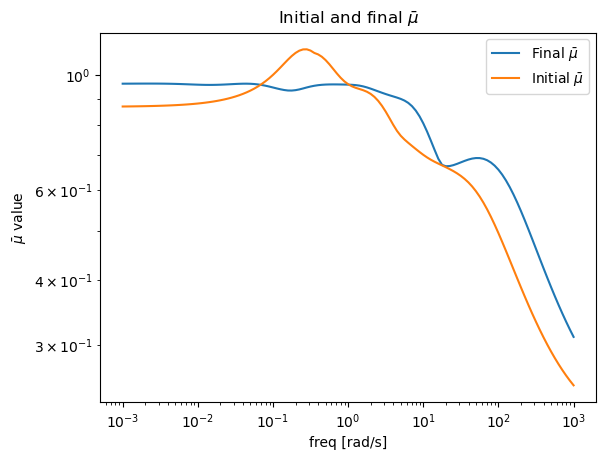

In [6]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'Initial and final $\bar\mu$')

Verify performance on the nominal system. It must hold that $\|W_e S\|_\infty \leq \bar\nu$ for $\bar\nu=\sup_\omega \bar\mu$. 

0 states have been removed from the model


Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for the nominal system')

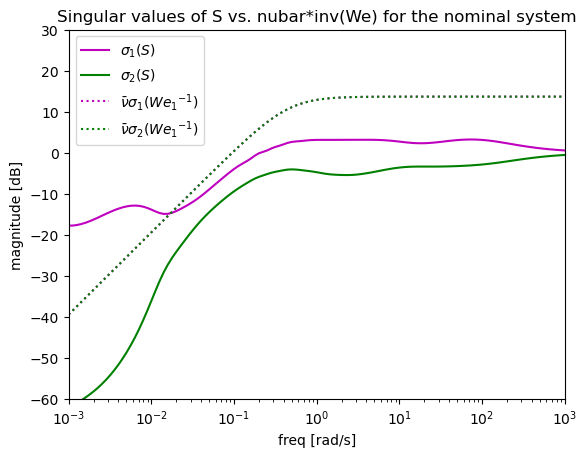

In [7]:
# Compute closed loop sensitivity for the nominal system
I = ct.ss([], [], [], np.eye(2)) # Identity system  

S = ct.minreal(ct.feedback(I,P*K))

# Compute singular values of S over frequency
Ssv = rb.sigma(S, omega)

# We plot the singular values of gamma*invss(We) along with S
# for gamma = best_mu_upper_bound
Weinv = rb.invss(We)
Weinvsv = rb.sigma(Weinv, omega) * best_nubar

plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of S vs. nubar*inv(We) for the nominal system')

4 states have been removed from the model
0 states have been removed from the model


Text(0.5, 1.0, 'Singular values of Sp vs. nubar*inv(We) for the perturbed system')

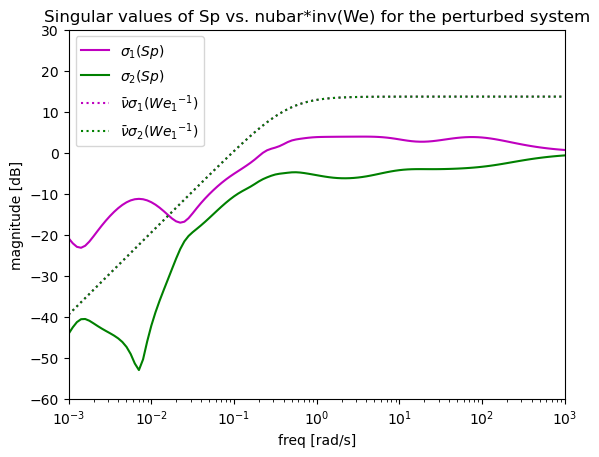

In [8]:
# Compute a perturbed plant by an admissible perturbation on the gain
# Note that the actual max perturbation on the gain is gainmax/best_nubar
Pp = ct.minreal(np.diag([1+0.95*gainmax/best_nubar, 1+0.95*gainmax/best_nubar])*P)

# Plot the sensitivity as above to verify robust performance
Sp = ct.minreal(ct.feedback(I,Pp*K))
Spsv = rb.sigma(Sp, omega)
plt.semilogx(omega, 20*np.log10(Spsv[:, 0]), 'm', label=r'$\sigma_1(Sp)$')
plt.semilogx(omega, 20*np.log10(Spsv[:, 1]), 'g', label=r'$\sigma_2(Sp)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of Sp vs. nubar*inv(We) for the perturbed system')

4 states have been removed from the model
1 states have been removed from the model


Text(0.5, 1.0, 'Singular values of Sp2 vs. nubar*inv(We) for the perturbed system')

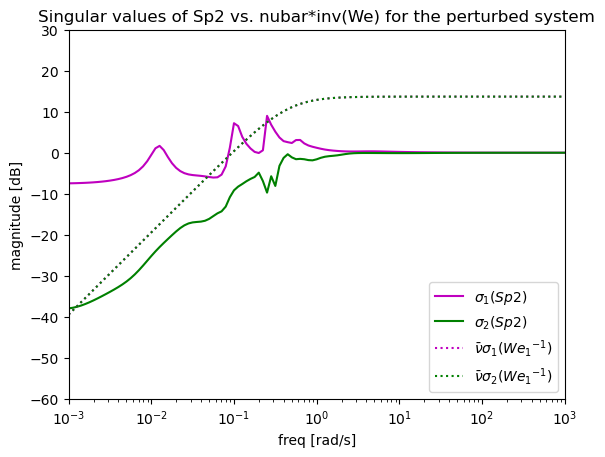

In [9]:
# Compute a perturbed plant by an admissible perturbation on the dynamics
# This perturbation is admissible only if the achieved mubar is less than 1,
# otherwise it should be scaled but it is not easy to compute the scaling
Pdyn = ct.ss(1/(1+0.95*taumax*s))
Pdyn = Pdyn.append(Pdyn)
Pp2 = ct.minreal(P * Pdyn)

# Plot the sensitivity as above to verify robust performance
Sp2 = ct.minreal(ct.feedback(I,Pp2*K))
Sp2sv = rb.sigma(Sp2, omega)
plt.semilogx(omega, 20*np.log10(Sp2sv[:, 0]), 'm', label=r'$\sigma_1(Sp2)$')
plt.semilogx(omega, 20*np.log10(Sp2sv[:, 1]), 'g', label=r'$\sigma_2(Sp2)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of Sp2 vs. nubar*inv(We) for the perturbed system')

Especially at low frequencies, it may happen that the performance specification is apparently violated. This is due to numerical problems because the orders of the systems involved (especially the controller) are high. This can be avoided using model reduction (see _kreduction script).

6 states have been removed from the model
1 states have been removed from the model


Text(0.5, 1.0, 'Singular values of Sp3 vs. nubar*inv(We) for the perturbed system')

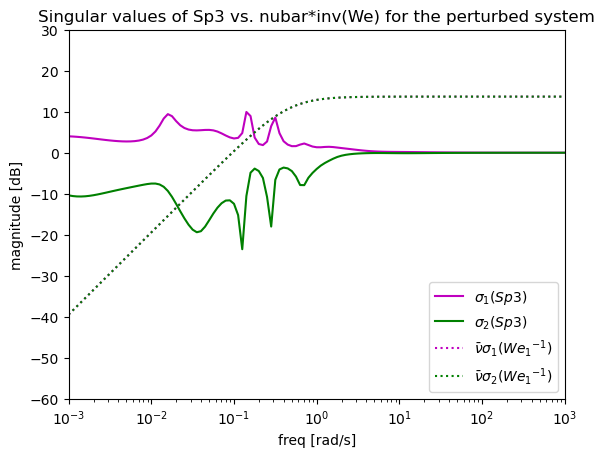

In [10]:
# Now perturb both the gain and the dynamics
Pp3 = ct.minreal(np.diag([1+0.95*gainmax/best_nubar, 1+0.95*gainmax/best_nubar])*Pp2) 

# Plot the sensitivity as above to verify robust performance
Sp3 = ct.minreal(ct.feedback(I,Pp3*K))
Sp3sv = rb.sigma(Sp3, omega)
plt.semilogx(omega, 20*np.log10(Sp3sv[:, 0]), 'm', label=r'$\sigma_1(Sp3)$')
plt.semilogx(omega, 20*np.log10(Sp3sv[:, 1]), 'g', label=r'$\sigma_2(Sp3)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of Sp3 vs. nubar*inv(We) for the perturbed system')